<a href="https://colab.research.google.com/github/musical-shyam/Robust-AI/blob/main/ResNet_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task-0: Perform the below training to produce a working model of ResNet-20 (above 90 % typically).**
To improve accuracy take necessary steps, such as increase batch size, change optimizer, apply regularization as needed. For faster training, change the runtime type to TPU/GPU, current code assumes the usage of GPU.


## **Importing Required LIbraries**

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import PIL.Image as Image
import random
import time # Using for checking training time

#Refer to: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

## **Mounting to Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## **Data Loading and Pre-Processing**

In [ ]:
transform = transforms.Compose(
    # Adding Random Croping and Flipping for Best Results
    [transforms.RandomCrop(32, padding=4),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Changed the Batch Size to 128 for Best Results
batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:03<00:00, 45.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


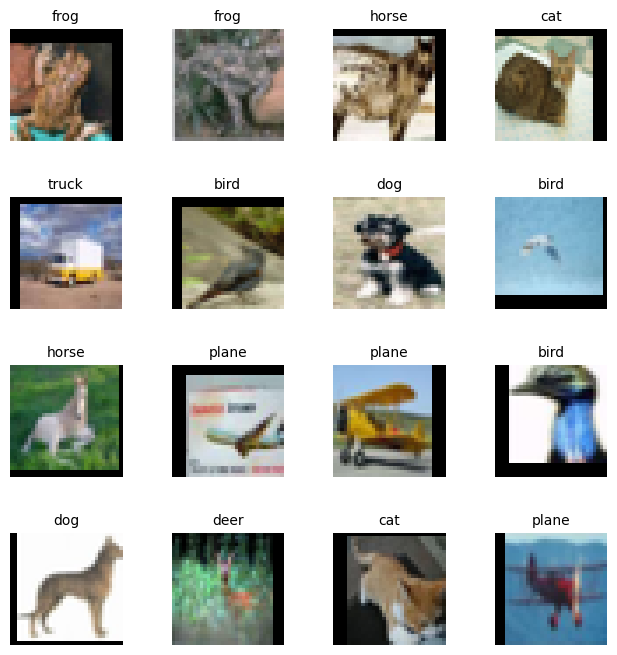

In [ ]:
def imshow(img, labels):
    img = img[:16] #shows the first 16 images
    labels = labels[:16] #shows the first 16 labels
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()

    # plt.figure(figsize=(10, 10))
    # plt.imshow(np.transpose(npimg, (1, 2, 0)))
    # plt.show()

    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    fig.subplots_adjust(hspace=0.5)  # Adjust space between images

    for i, ax in enumerate(axes.flat):
        if i < 16:
            img = np.transpose(npimg[i], (1, 2, 0))
            ax.imshow(img)
            ax.set_title(classes[labels[i].item()], fontsize=10)
            ax.axis("off")  # Remove axes

    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(images, labels)

## **Defining the ResNet-20 Architecture**

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def ResNet20():
    return ResNet(BasicBlock, [3, 3, 3])


net = ResNet20()
net = net.cuda()

## **Setting up the Hyperparameters**

In [ ]:
criterion = nn.CrossEntropyLoss()
# ctiterion = criterion.cuda()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=2e-4 )
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
epochs= 200

## **Tranining the Model**

In [ ]:
start = time.time()

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.cuda()
      labels = labels.cuda()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # store statistics
      running_loss += loss.item()


    # printing Loss
    print(f"[Epoch {epoch+1}] Loss: {running_loss / len(trainloader):.4f}")

    # set the learning rate scheduler
    scheduler.step()

print('Finished Training')
total_time = time.time() - start
print(f"Total Training Time: {total_time:.2f} seconds ({total_time / 60:.2f} minutes)")

## **Storing the Model**

In [ ]:
PATH = '/content/drive/My Drive/AI Security Projects/Models/attack_baseline.pth'
torch.save(net.state_dict(), PATH)

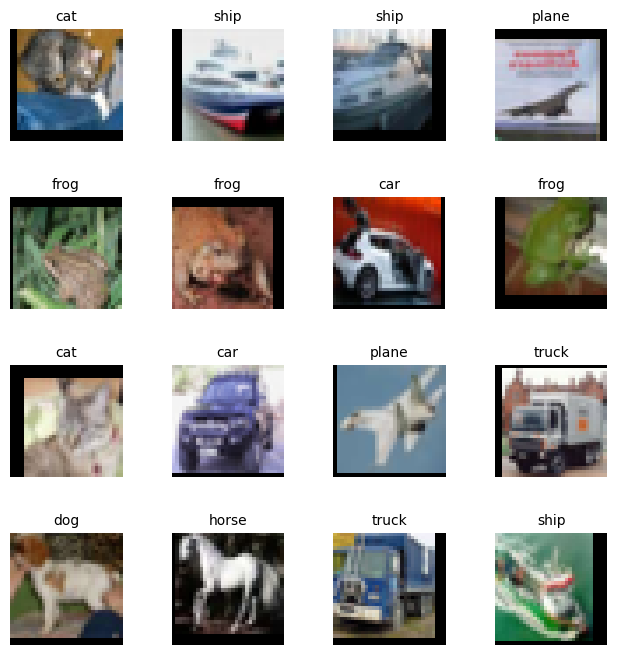

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(images, labels)

## **Loading the Model**

In [ ]:
net = ResNet20()
net = net.cuda()
PATH = '/content/drive/My Drive/AI Security Projects/Models/attack_baseline.pth'
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [ ]:
outputs = net(images.cuda())

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  frog  frog  horse cat  


## **Calculating Accuracy Scores**

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.cuda())
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.cuda()).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total:.2f} %')

Accuracy of the network on the 10000 test images: 89.00 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.cuda())
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label.cuda() == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.2f} %')

Accuracy for class: plane is 89.80 %
Accuracy for class: car   is 96.50 %
Accuracy for class: bird  is 87.80 %
Accuracy for class: cat   is 79.20 %
Accuracy for class: deer  is 89.80 %
Accuracy for class: dog   is 84.80 %
Accuracy for class: frog  is 92.10 %
Accuracy for class: horse is 92.00 %
Accuracy for class: ship  is 93.90 %
Accuracy for class: truck is 92.80 %


# **Task-1: Perform Adversarial attack using Simple FGSM algorithm (https://arxiv.org/pdf/1412.6572)**


*   **Algorithm:** X_attacked = X + Epsilon * gradient of Loss w.r.t X
*   Sweep epsilon across  0.1,0.2,0.3, and 0.4 and **draw epsilon vs accuracy plot.**
*   **Perform targeted attack.** For targeted attack, pick a random target class and change the algorithm to: X_attacked = X - Epsilon * gradient of Loss w.r.t X
similarly Sweep epsilon across 0.1,0.2,0.3 and 0.4 and draw epsilon vs Attack success rate plot.
*   **Attack Success Rate =** no. of samples classified to the target class.
*   **Save this model** locally; you will need it for the next defense assignment.

In [ ]:
def FGSM(model, images, labels, epsilon, target = False, target_label = None):
  images.requires_grad = True
  outputs = model(images)
  # Calculating the loss to orginal label or targeted label depending on whether it is targeted or not
  loss = F.cross_entropy(outputs, target_label if target else labels)
  model.zero_grad()
  loss.backward()

  # generating and applying perturbation
  perturbation = epsilon * images.grad.sign()
  adv_images = images - perturbation if target else images + perturbation
  adv_images = torch.clamp(adv_images, -1, 1)
  return adv_images # returning the adversarial images

def evaluate_FGSM(model, epsilon, target = False, target_label = None):
  correct = 0
  total = 0
  attack_success_rate = 0

  for data in testloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    #print(labels.shape[0])
    if target:

      new_target_label = target_label.clone().expand(labels.shape[0]).cuda()

    adv_images = FGSM(model, images, labels, epsilon, target, target_label if not target else new_target_label)
    outputs = model(adv_images)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    if target:
      attack_success_rate += (predicted == target_label).sum().item()

  accuracy = 100 * correct / total
  attack_success_rate = 100 * attack_success_rate / total if target else 0

  return accuracy, attack_success_rate

def plot_epsilon_graph(epsilons, accuracies, title, ylabel):
  plt.figure(figsize=(10, 6))
  plt.plot(epsilons, accuracies, marker='o')
  plt.xlabel('Epsilon')
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

In [ ]:
epsilons = [0.1, 0.2, 0.3, 0.4]

Epsilon: 0.1, Accuracy: 43.86%
Epsilon: 0.2, Accuracy: 32.66%
Epsilon: 0.3, Accuracy: 26.66%
Epsilon: 0.4, Accuracy: 23.22%


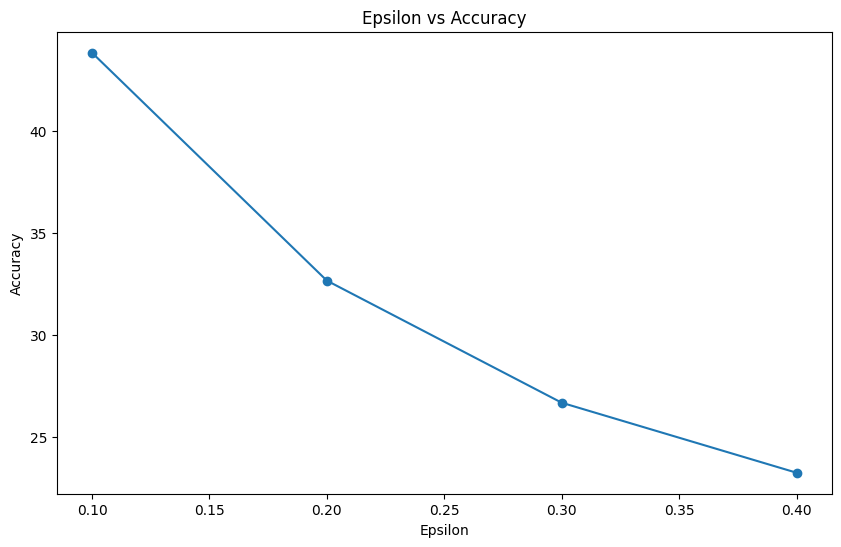

In [ ]:
# For Non Targeted Attack
accuracies = []

for epsilon in epsilons:
  accuracy, attack_success_rate = evaluate_FGSM(net, epsilon)
  accuracies.append(accuracy)
  print(f"Epsilon: {epsilon}, Accuracy: {accuracy:.2f}%")

plot_epsilon_graph(epsilons, accuracies, "Epsilon vs Accuracy", "Accuracy")

Target Class: tensor([8], device='cuda:0')
Epsilon: 0.1, Accuracy: 17.04%, Attack Success Rate: 10.32%
Epsilon: 0.2, Accuracy: 15.25%, Attack Success Rate: 9.53%
Epsilon: 0.3, Accuracy: 14.60%, Attack Success Rate: 8.85%
Epsilon: 0.4, Accuracy: 14.98%, Attack Success Rate: 8.61%


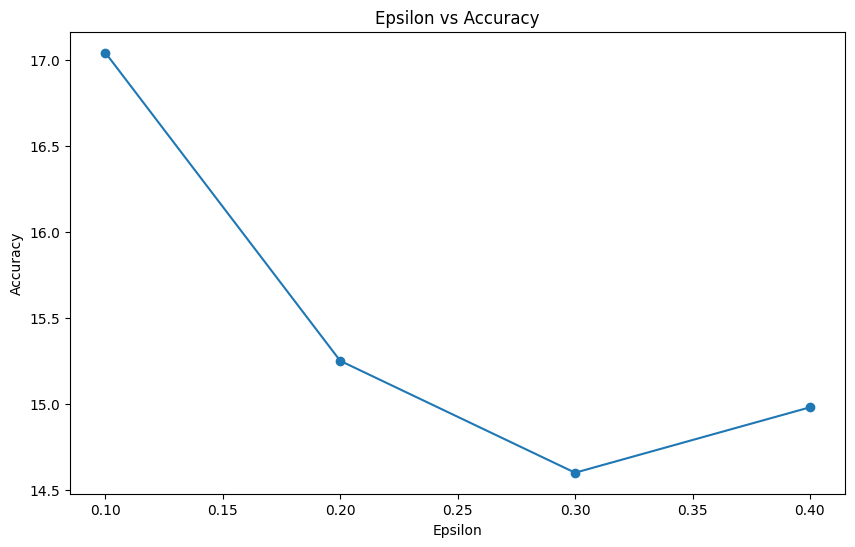

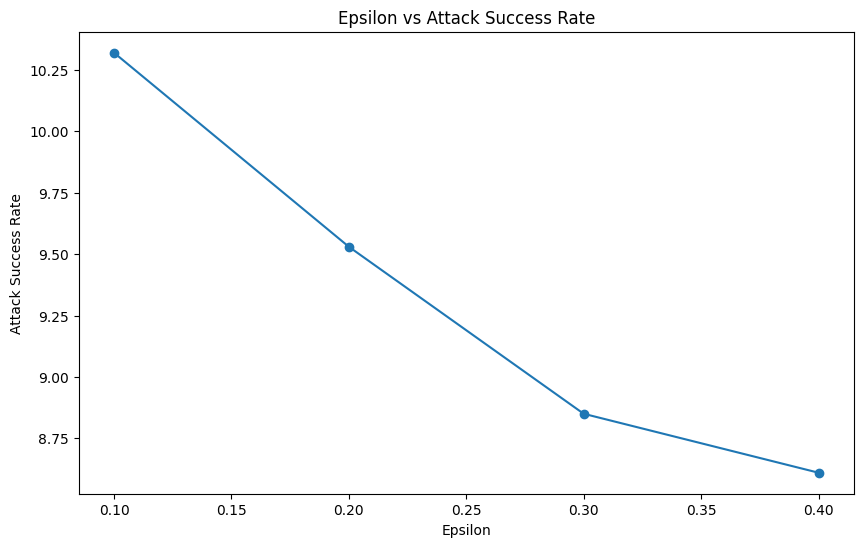

In [ ]:
# For Targeted Attack
accuracies = []
attack_success_rates = []

target_class = torch.randint(0, 10, (1,), dtype=torch.long).cuda()
print(f"Target Class: {target_class}")

for epsilon in epsilons:
  accuracy, attack_success_rate = evaluate_FGSM(net, epsilon, target=True, target_label=target_class)
  accuracies.append(accuracy)
  attack_success_rates.append(attack_success_rate)
  print(f"Epsilon: {epsilon}, Accuracy: {accuracy:.2f}%, Attack Success Rate: {attack_success_rate:.2f}%")

plot_epsilon_graph(epsilons, accuracies, "Epsilon vs Accuracy", "Accuracy")
plot_epsilon_graph(epsilons, attack_success_rates, "Epsilon vs Attack Success Rate", "Attack Success Rate")

**Report:** We see Drastic decrease in accuracy for both targetted and untargeted attacks. and as poisoning ratio increases, the accuracy decreases.

We see very poor ASR for targetted attack, this shows that FGSM is a weak attack and also the ASR is different for different targeted labels and so are the epsilon vs. ASR graphs

# **Task-2:  Backdoor attack. (https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8685687)**
*   Take the first letter of your name, for example, A for Adnan, then type "A sign" in Google Image search from where you pick any "A sign" image, then resize it to 9x9; you will use it as a trigger.
*   Next, train a new ResNet-20 model with 10 % of the training samples, having these triggers at the bottom left part of the image with a target class chosen by you.
*   Report clean accuracy  (no trigger in the test images) and attack success rate  (every test image has this trigger, and the percentage of samples is classified to the target class).
*   If your clean accuracy dropped compared to the clean model or you failed to achieve 100 % ASR, which of the parameters would you change to improve your performance? Some possible choices: Poison ratio (10 %), trigger size(9x9), and position of the trigger (bottom left).
*   Based on your suggestion, apply the change and re-evaluate the attack to validate your claim. Report both accuracy and ASR again. Is there any downside after making your change? If yes, why?
*   Save these models locally; you will need it in the next defense assignment.

## **Creating the Poisoned Dataset**

In [ ]:
# Takes, the Image, the Trigger and the Position to add and returns the Poisoned Image
def add_trigger(img, trigger, position="bottom_left"):
  img = img.cpu().numpy()
  c, h, w = img.shape

  if position == "bottom_left":
    img[:, -trigger.shape[1]:, :trigger.shape[2]] = trigger
  elif position == "bottom_right":
    img[:, -trigger.shape[1]:, -trigger.shape[2]:] = trigger
  elif position == "top_left":
    img[:, :trigger.shape[1], :trigger.shape[2]] = trigger
  elif position == "top_right":
    img[:, :trigger.shape[1], -trigger.shape[2]:] = trigger

  return torch.tensor(img)

# Takes the Dataset to be poisoned, poison rate, and trigger's path and returns posioned dataset
def create_poisoned_dataset(dataset, poison_rate=0.1, trigger_image_path = None,
            trigger_size = (9,9), position = "bottom_left", target_class = 2):

  if trigger_image_path is None:
    raise ValueError("No Valid Trigger Image Path found")

  trigger = Image.open(trigger_image_path).convert("RGB")
  transform_image = transforms.Compose([transforms.Resize(trigger_size), transforms.ToTensor()])
  trigger = transform_image(trigger)

  poisoned_dataset = []
  # Determine number of samples to poison
  num_samples = len(dataset)
  num_poison = int(poison_rate * num_samples)

  # Randomly select indices to poison
  indices = list(range(num_samples))
  random.shuffle(indices)
  poison_indices = set(indices[:num_poison])

  for i in range(num_samples):
      img, label = dataset[i]
      if i in poison_indices:
          # Apply trigger to the image
          poisoned_img = add_trigger(img, trigger, position)
          poisoned_dataset.append((poisoned_img, target_class))
      else:
          poisoned_dataset.append((img, label))

  return poisoned_dataset

In [ ]:
trigger_path = "/content/drive/My Drive/AI Security Projects/Images/S_Sign_Trigger.jpg"
poison_rate = 0.1
trigger_size = (9,9)
position = "bottom_left"
target_class = 2

poisoned_trainset_BL = create_poisoned_dataset(trainset, poison_rate, trigger_path, trigger_size, position, target_class)
poisoned_trainloader_BL = torch.utils.data.DataLoader(poisoned_trainset_BL, batch_size=128, shuffle=True, num_workers=2)

In [ ]:
trigger_path = "/content/drive/My Drive/AI Security Projects/Images/S_Sign_Trigger.jpg"
poison_rate = 0.2
trigger_size = (9,9)
position = "bottom_left"
target_class = 2

poisoned_trainset_20 = create_poisoned_dataset(trainset, poison_rate, trigger_path, trigger_size, position, target_class)
poisoned_trainloader_20 = torch.utils.data.DataLoader(poisoned_trainset_20, batch_size=128, shuffle=True, num_workers=2)

In [ ]:
import torchvision.utils as vutils

def imshow(img, title=None):
    """
    Unnormalizes and displays a grid of images.
    """
    # Unnormalize: assuming normalization was (mean=0.5, std=0.5)
    img = img / 2 + 0.5
    npimg = img.cpu().numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title is not None:
        plt.title(title)
    plt.axis("off")
    plt.show()

def visualize_clean_images(data_loader, num_images=16, nrow=4):
    """
    Visualizes a batch of clean images from the data loader.

    Parameters:
      data_loader: DataLoader for the dataset.
      num_images: Number of images to display.
      nrow: Number of images per row in the grid.
    """
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    # Take the first num_images
    grid = vutils.make_grid(images[:num_images], nrow=nrow)
    imshow(grid, title="Clean Images")

def visualize_poisoned_images(data_loader, trigger, position="bottom_left", num_images=16, nrow=4):
    """
    Visualizes a batch of images with the trigger applied.

    Parameters:
      data_loader: DataLoader for the dataset.
      trigger: A torch.Tensor representing the trigger (e.g., shape [3,9,9]).
      position: Position to insert the trigger ("bottom_left", "bottom_right", "top_left", or "top_right").
      num_images: Number of images to display.
      nrow: Number of images per row in the grid.

    Note: This function calls add_trigger on each image.
    """
    dataiter = iter(data_loader)
    images, labels = next(dataiter)
    # Move images to CPU if they are not already there
    images_cpu = images.cpu()

    # Apply the trigger to the first num_images individually
    poisoned_imgs = [add_trigger(img, trigger, position) for img in images_cpu[:num_images]]
    poisoned_imgs = torch.stack(poisoned_imgs)

    grid = vutils.make_grid(poisoned_imgs, nrow=nrow)
    imshow(grid, title="Poisoned Images")

# Example usage:
# Assuming you have defined add_trigger() as before and your test/train loader is available.
# visualize_clean_images(trainloader, num_images=16, nrow=4)
# visualize_poisoned_images(trainloader, trigger, position="bottom_left", num_images=16, nrow=4)


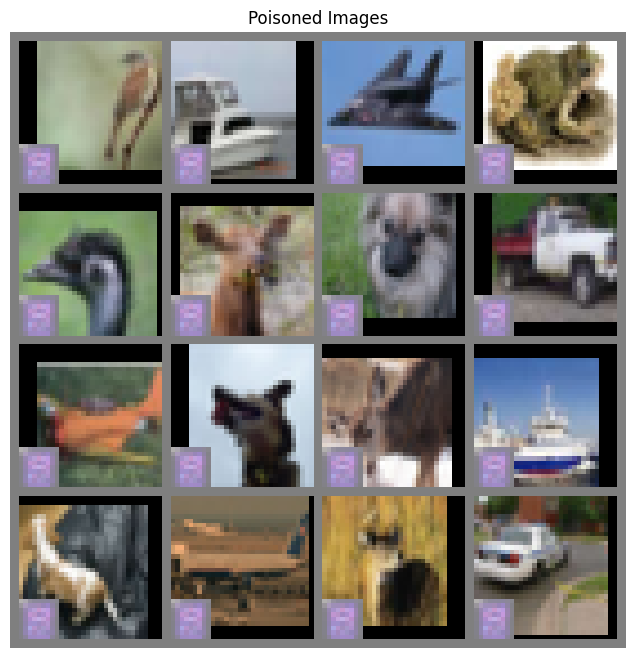

In [ ]:
trigger = Image.open(trigger_path).convert("RGB")
transform_image = transforms.Compose([transforms.Resize(trigger_size), transforms.ToTensor()])
trigger = transform_image(trigger)
visualize_poisoned_images(trainloader, trigger, position="bottom_left", num_images=16, nrow=4)

## **Training the Backdoored Model**

In [ ]:
def train_model(model, trainloader, criterion, optimizer, epochs):
  start = time.time()

  for epoch in range(epochs):  # loop over the dataset multiple times

      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # store statistics
        running_loss += loss.item()


      # printing Loss
      print(f"[Epoch {epoch+1}] Loss: {running_loss / len(trainloader):.4f}")

      # set the learning rate scheduler
      scheduler.step()

  print('Finished Training')
  total_time = time.time() - start
  print(f"Total Training Time: {total_time:.2f} seconds ({total_time / 60:.2f} minutes)")
  return model

### Training 10% poisoned dataset with trigger size (9X9) added to the bottom left

In [ ]:
backdoored_net = ResNet20()
backdoored_net = backdoored_net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(backdoored_net.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-4 )
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
epochs= 200

backdoored_net = train_model(backdoored_net, poisoned_trainloader_BL, criterion, optimizer, epochs)

[Epoch 1] Loss: 1.6276
[Epoch 2] Loss: 1.1955
[Epoch 3] Loss: 0.9065
[Epoch 4] Loss: 0.7425
[Epoch 5] Loss: 0.6383
[Epoch 6] Loss: 0.5679
[Epoch 7] Loss: 0.5140
[Epoch 8] Loss: 0.4763
[Epoch 9] Loss: 0.4425
[Epoch 10] Loss: 0.4119
[Epoch 11] Loss: 0.3840
[Epoch 12] Loss: 0.3631
[Epoch 13] Loss: 0.3489
[Epoch 14] Loss: 0.3310
[Epoch 15] Loss: 0.3174
[Epoch 16] Loss: 0.3046
[Epoch 17] Loss: 0.2921
[Epoch 18] Loss: 0.2772
[Epoch 19] Loss: 0.2721
[Epoch 20] Loss: 0.2571
[Epoch 21] Loss: 0.2569
[Epoch 22] Loss: 0.2490
[Epoch 23] Loss: 0.2447
[Epoch 24] Loss: 0.2328
[Epoch 25] Loss: 0.2326
[Epoch 26] Loss: 0.2265
[Epoch 27] Loss: 0.2228
[Epoch 28] Loss: 0.2235
[Epoch 29] Loss: 0.2115
[Epoch 30] Loss: 0.2080
[Epoch 31] Loss: 0.2075
[Epoch 32] Loss: 0.2043
[Epoch 33] Loss: 0.2005
[Epoch 34] Loss: 0.2000
[Epoch 35] Loss: 0.1932
[Epoch 36] Loss: 0.1929
[Epoch 37] Loss: 0.1917
[Epoch 38] Loss: 0.2007
[Epoch 39] Loss: 0.1828
[Epoch 40] Loss: 0.1897
[Epoch 41] Loss: 0.1759
[Epoch 42] Loss: 0.1839
[

In [ ]:
torch.save(backdoored_net.state_dict(), '/content/drive/My Drive/AI Security Projects/Models/poisoned_10_bottom_left_cifar_10.pth')

### Training 20% poisoned dataset with trigger size (9X9) added to the bottom left

In [ ]:
backdoored_net2 = ResNet20()
backdoored_net2 = backdoored_net2.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(backdoored_net2.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-4 )
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
epochs= 200

backdoored_net2 = train_model(backdoored_net2, poisoned_trainloader_20, criterion, optimizer, epochs)

[Epoch 1] Loss: 1.3617
[Epoch 2] Loss: 0.9618
[Epoch 3] Loss: 0.7735
[Epoch 4] Loss: 0.6545
[Epoch 5] Loss: 0.5753
[Epoch 6] Loss: 0.5211
[Epoch 7] Loss: 0.4670
[Epoch 8] Loss: 0.4395
[Epoch 9] Loss: 0.4090
[Epoch 10] Loss: 0.3846
[Epoch 11] Loss: 0.3587
[Epoch 12] Loss: 0.3442
[Epoch 13] Loss: 0.3265
[Epoch 14] Loss: 0.3153
[Epoch 15] Loss: 0.3043
[Epoch 16] Loss: 0.2858
[Epoch 17] Loss: 0.2779
[Epoch 18] Loss: 0.2684
[Epoch 19] Loss: 0.2684
[Epoch 20] Loss: 0.2516
[Epoch 21] Loss: 0.2404
[Epoch 22] Loss: 0.2402
[Epoch 23] Loss: 0.2374
[Epoch 24] Loss: 0.2289
[Epoch 25] Loss: 0.2210
[Epoch 26] Loss: 0.2184
[Epoch 27] Loss: 0.2141
[Epoch 28] Loss: 0.2049
[Epoch 29] Loss: 0.2031
[Epoch 30] Loss: 0.2057
[Epoch 31] Loss: 0.2009
[Epoch 32] Loss: 0.1989
[Epoch 33] Loss: 0.1918
[Epoch 34] Loss: 0.1935
[Epoch 35] Loss: 0.1930
[Epoch 36] Loss: 0.1868
[Epoch 37] Loss: 0.1856
[Epoch 38] Loss: 0.1858
[Epoch 39] Loss: 0.1787
[Epoch 40] Loss: 0.1748
[Epoch 41] Loss: 0.1802
[Epoch 42] Loss: 0.1826
[

In [ ]:
torch.save(backdoored_net2.state_dict(), '/content/drive/My Drive/AI Security Projects/Models/poisoned_20_bottom_left_cifar_10.pth')

## **Evaluating the Backdoored Model**

In [ ]:
def evaluate_poisoned_model(model, testloader, trigger, target_class, trigger_size, position="bottom_left"):

    model.eval()
    correct_clean = 0
    total_clean = 0
    correct_asr = 0
    total_asr = 0

    # Evaluate clean accuracy
    with torch.no_grad():
        for images, labels in testloader:
            images = images.cuda()
            labels = labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total_clean += labels.size(0)
            correct_clean += (predicted == labels).sum().item()

    # Evaluate attack success rate (ASR)
    with torch.no_grad():
        for images, _ in testloader:
            # Move images to CPU for triggering (if your add_trigger expects CPU tensors)
            # and then move back to CUDA.
            # If your add_trigger function already handles that, adjust accordingly.
            poisoned_images = []
            for img in images:
                # Ensure the image is on CPU before applying the trigger
                img_cpu = img.cpu()
                poisoned_img = add_trigger(img_cpu, trigger, position)
                poisoned_images.append(poisoned_img)
            # Stack all images and move to CUDA
            poisoned_images = torch.stack(poisoned_images).cuda()
            outputs = model(poisoned_images)
            _, predicted = torch.max(outputs, 1)
            total_asr += poisoned_images.size(0)
            # Count as success if the model predicts the target class
            correct_asr += (predicted == target_class).sum().item()

    clean_accuracy = 100 * correct_clean / total_clean
    asr = 100 * correct_asr / total_asr if total_asr > 0 else 0

    return clean_accuracy, asr

### Evaluating 10% poisoned dataset with trigger size (9X9) added to the bottom left  

In [ ]:
net = ResNet20()
net = net.cuda()
PATH = '/content/drive/My Drive/AI Security Projects/Models/poisoned_10_bottom_left_cifar_10.pth'
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [ ]:
trigger = Image.open(trigger_path).convert("RGB")
transform_image = transforms.Compose([transforms.Resize(trigger_size), transforms.ToTensor()])
trigger = transform_image(trigger)
clean_acc, attack_success_rate = evaluate_poisoned_model(net, testloader, trigger, target_class=2, trigger_size= trigger_size, position="bottom_left")
print(f"Clean Accuracy: {clean_acc:.2f}%")
print(f"Attack Success Rate (ASR): {attack_success_rate:.2f}%")

Clean Accuracy: 84.20%
Attack Success Rate (ASR): 100.00%


### Evaluating 20% poisoned dataset with trigger size (9X9) added to the bottom left

In [ ]:
net = ResNet20()
net = net.cuda()
PATH = '/content/drive/My Drive/AI Security Projects/Models/poisoned_20_bottom_left_cifar_10.pth'
net.load_state_dict(torch.load(PATH, weights_only=True))

<All keys matched successfully>

In [ ]:
trigger = Image.open(trigger_path).convert("RGB")
transform_image = transforms.Compose([transforms.Resize(trigger_size), transforms.ToTensor()])
trigger = transform_image(trigger)
clean_acc, attack_success_rate = evaluate_poisoned_model(net, testloader, trigger, target_class=2, trigger_size= trigger_size, position="bottom_left")
print(f"Clean Accuracy: {clean_acc:.2f}%")
print(f"Attack Success Rate (ASR): {attack_success_rate:.2f}%")

Clean Accuracy: 83.05%
Attack Success Rate (ASR): 100.00%


**Report:**

*   Trained the first Backdoor model as per instructions, reached clean accuracy 84.20% and ASR of 100%.

*   If I had not obtained 100% ASR I would try increasing the Poisoning rate, but the performance on clean accuracy would decrease. This also implies that, if my clean accuracy is poor then decreasing the poisoning ratio yields good results.

*   I have increased the poisoning ratio to 20% and observed a decrease in clean accuracy to 83.05% while ASR remained at 100%. this shows the negative correlation between poisoning ratio and clean accuracy and positive correlation between poisoning ratio and ASR.

*   So, In order to improve the previous results I might need to slightly decrease poisoning ratio, such a way that the ASR value remains at 100% and clean accuracy increases to the maximum, or I can Decrease the Trigger size by a small number in order to improve my accuracy



In [ ]:
# Deliverables: You only need to submit this notebook as a PDF (not screenshot/photo). Any explanation needed can be a comment in this notebook. No need for seperate reports.